In [72]:
import numpy as np
import functions_TE
import importlib
importlib.reload(functions_TE)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [73]:
#plotting options
blue = sns.color_palette()[0]
red = sns.color_palette()[1]
green = sns.color_palette()[2]
yellow = sns.color_palette()[4]

# Seed for reproduceability
np.random.seed(1234)

In [74]:
S0 = 3e-2 # mol/L
theta = 20.0 / 60 # min
k_cat = 0.14 * 60 # 1/min
K_m = 1.5e-2 # mol/L

par = [S0, theta, k_cat, K_m]

In [75]:
S_init = 2e-2 # mol/L
E_init = 0 # mol/L

init = [S_init, E_init]

In [76]:
datasets = 10
t_max = 100
t_step = 3
t_points = 10

S, E, E0, t, t_E0 = functions_TE.ODE_int2(datasets, t_max, t_step, t_points, par)

In [77]:
E0_mean = (0.01 - 0) / 2
E0_std = (0.01 - 0) / np.sqrt(12)
S_mean = np.mean(S[:-1,:,:])
S_std = np.std(S[:-1,:,:])
E_mean = np.mean(E[:-1,:,:])
E_std = np.std(E[:-1,:,:])

S_norm = (S - S_mean) / S_std
E_norm = (E - E_mean) / E_std
E0_norm = (E0 - E0_mean) / E0_std

Text(0.5, 0, 'Time [min]')

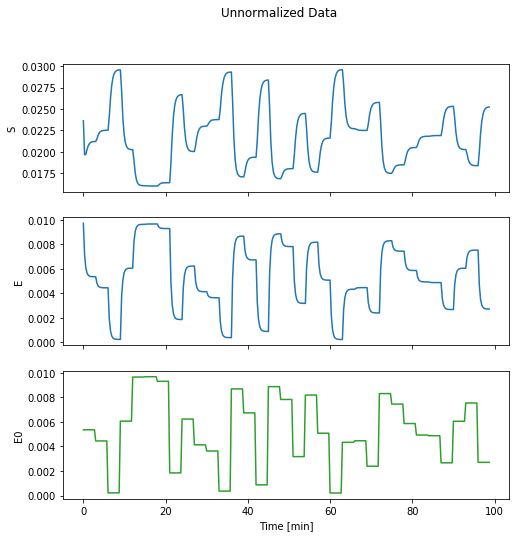

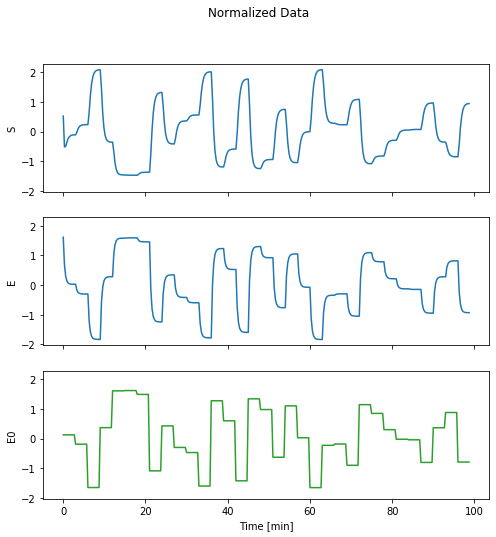

In [78]:
index = -1

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_plot = S[index,:,:].flatten()
E_plot = E[index,:,:].flatten()
E0_plot = E0[index,:,:].flatten()

S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8,8))
plt.suptitle('Unnormalized Data')
ax1.plot(t_plot, S_plot, c=blue)
ax1.set_ylabel('S')

ax2.plot(t_plot, E_plot, c=blue)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue)
ax1.set_ylabel('S')

ax2.plot(t_plot, E_norm_plot, c=blue)
ax2.set_ylabel('E')

ax3.plot(t_E0_plot, E0_norm_plot, c=green)
ax3.set_ylabel('E0')

plt.xlabel('Time [min]')


In [79]:
skip = 0

#Training
train_in = np.array([S_norm[:-1,:,skip:-1].flatten(), E0_norm[:-1,:,skip:-1].flatten()]).transpose()
train_pred = np.array([S_norm[:-1,:,skip+1:].flatten()]).transpose()
# train_pred = np.array([S_norm[:-1,:,skip+1:].flatten(), E_norm[:-1,:,skip+1:].flatten(), E0_norm[:-1,:,skip+1:].flatten()]).transpose()
test = np.array([S_norm[-1,:,:].flatten(), E0_norm[-1,:,:].flatten()]).transpose()

print(train_in.shape)
print(train_pred.shape)



(2970, 2)
(2970, 1)


In [80]:
importlib.reload(functions_TE)

HL = 3
HL_Nodes = 20
Activation = 'softplus'
learning_rate_pred = 1e-3 # default is 1e-3
h = t[0,0,1] - t[0,0,0]

RK4_model = functions_TE.RK4_Integrator_Model2(HL_Nodes, Activation, learning_rate_pred, h)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_pred)
RK4_model.build(train_in.shape)
RK4_model.compile(optimizer=optimizer,
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
RK4_model.summary()


Model: "r_k4__integrator__model2_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             multiple                  60        
_________________________________________________________________
dense_49 (Dense)             multiple                  420       
_________________________________________________________________
dense_50 (Dense)             multiple                  420       
_________________________________________________________________
dense_51 (Dense)             multiple                  21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import kerasUtils
importlib.reload(kerasUtils)

Pbar = kerasUtils.Pbar
batch_size = 50
Epoch_Num = 1000
history = RK4_model.fit(train_in,train_pred,
                          batch_size=batch_size,
                          epochs=Epoch_Num, validation_split=0.1, verbose=False, shuffle=True, 
                          callbacks=[Pbar(Epoch_Num)]
                         )

plt.plot(np.log(history.history['loss']), label='training data')
plt.plot(np.log(history.history['val_loss']), label='validation data')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


Training:  18%|█▊        | 179/1000 [00:51<03:24,  4.02Epoch/s]

In [ ]:
import tensorflow as tf
index = -1
test = np.array([S_norm[index,:,:].flatten(), E0_norm[index,:,:].flatten()]).transpose()

pred_offline = np.zeros(np.shape(test))
pred_offline[0,:] = test[0,:]
pred_offline[:,1] = test[:,1]

for i in range(np.shape(test)[0] - 1):
    input = pred_offline[i,:].reshape(1,2)
    output = RK4_model.predict(input)
    pred_offline[i+1,0] = output[0,0]
    

In [ ]:
Error_Offline = np.sum((test - pred_offline) ** 2) / np.size(test)
print(Error_Offline)

In [ ]:
# index = 0

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

S_pred = pred_offline[:,0]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Predicted Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue, label='Actual')
ax1.plot(t_plot, S_pred, c=red, label='Offline Prediction')
ax1.legend()
ax1.set_ylabel('S')

ax2.plot(t_E0_plot, E0_norm_plot, c=green)
ax2.set_ylabel('E0')

plt.xlabel('Time [min]')

In [ ]:
index = -1
test = np.array([S_norm[index,:,:].flatten(), E0_norm[index,:,:].flatten()]).transpose()

pred_online = np.zeros(np.shape(test))
pred_online[0,:] = test[0,:]
pred_online[:,1] = test[:,1]

for i in range(np.shape(test)[0] - 1):
    input = test[i,:].reshape(1,2)
    output = RK4_model.predict(input)
    pred_online[i+1,0] = output[0,0]

In [ ]:
Error_Online = np.sum((test - pred_online) ** 2) / np.size(test)
print(Error_Online)

In [ ]:
# index = 0

t_plot = t[index,:,:].flatten()
t_E0_plot = t_E0[index,:,:].flatten()
S_norm_plot = S_norm[index,:,:].flatten()
E_norm_plot = E_norm[index,:,:].flatten()
E0_norm_plot = E0_norm[index,:,:].flatten()

S_pred = pred_online[:,0]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Predicted Normalized Data')
ax1.plot(t_plot, S_norm_plot, c=blue, label='Actual')
ax1.plot(t_plot, S_pred, c=red, label='Online Pred')
ax1.legend()
ax1.set_ylabel('S')

ax2.plot(t_E0_plot, E0_norm_plot, c=green)
ax2.set_ylabel('E0')

plt.xlabel('Time [min]')


In [ ]:
ANN1 = RK4_model.ANN1
ANN2 = RK4_model.ANN2
ANN3 = RK4_model.ANN3
ANNout = RK4_model.ANNout

# def myANN_ODE(t, inputs):
#     output = ANNout(
#                 ANN1(
#                 ANN2(
#                 ANN3(inputs))))
#     return output

inputs = tf.keras.Input(shape=(2,))
x = ANN3(inputs)
x = ANN2(x)
x = ANN1(x)
outputs = ANNout(x)

odeModel = tf.keras.Model(inputs=inputs, outputs=outputs)

def myANN_ODE(t, inputs, E0):
    argument = np.append(inputs, E0).reshape((1,2))
    output = odeModel.predict(argument)
    return output.reshape(1)

In [ ]:
datasets = 1
t_max = 30
t_step = 3
t_points = 100

S_difftest, E_difftest, E0_difftest, t_difftest, t_E0_difftest = functions_TE.ODE_int2(datasets, t_max, t_step, t_points, par)

S_norm_difftest = (S_difftest - S_mean) / S_std
E_norm_difftest = (E_difftest - E_mean) / E_std
E0_norm_difftest = (E0_difftest - E0_mean) / E0_std

# steps = 10
# E0_arr = np.zeros((steps))
# E0_mean = (0.01 - 0) / 2
# E0_std = (0.01 - 0) / np.sqrt(12)

# for i in range(steps):
#     E0_arr[i] = (np.random.uniform(0, 0.01) - E0_mean) / E0_std
E0_norm_flat = E0_norm_difftest[-1,:,:].flatten()
indexes = np.unique(E0_norm_flat, return_index=True)[1]
E0_arr = [E0_norm_flat[index] for index in sorted(indexes)]


In [ ]:
importlib.reload(functions_TE)
from scipy.integrate import solve_ivp

S_init = S_norm_difftest[-1,0,0]
E_init = E_norm_difftest[-1,0,0]

init = np.array([S_init])

# t_points = 5

y_ode =  t_points * len(E0_arr)
t_ode = np.zeros((len(E0_arr), t_points))
S_ode = np.zeros((len(E0_arr), t_points))
E_ode = np.zeros((len(E0_arr), t_points))
t_E0_ode = np.zeros((len(E0_arr), t_points))
E0_plot_ode = np.zeros((len(E0_arr), t_points))



t_start = 0
t_end = t_step

for j in range(len(E0_arr)):
    t_span = np.linspace(t_start, t_end, t_points, endpoint=False)
    E0_ode = np.zeros(t_span.shape) + E0_arr[j]
    
    # init = np.concatenate((init, [E0_ode[0]]))
    # init = np.append(init,[E0_ode[0]])
    #print(init)
    t_E0_ode[j,:] = t_span
    E0_plot_ode[j,:] = E0_ode
    
    # t_E0_ode[j,:] = [t_start, t_end]
    # E0_plot_ode[j,:] = [E0_ode[0], E0_ode[-1]]
    
    # print(init)
    sol = solve_ivp(myANN_ODE, [t_start, t_end], init, t_eval=t_span, args=[E0_ode[0]], method='BDF')
    t1_ode = sol.t
    S1_ode = sol.y
    t_ode[j,:] = t1_ode
    S_ode[j,:] = S1_ode

    t_start += t_step
    t_end += t_step
    init = [S1_ode[0,-1]]



In [ ]:
t_plot_ode = t_ode.flatten()
t_E0_plot_ode = t_E0_ode.flatten()

S_plot_ode = S_ode.flatten()
E0_plot_ode1 = E0_plot_ode.flatten()

S_plot_orig = S_norm_difftest[-1,:,:].flatten()
E0_plot_orig = E0_norm_difftest[-1,:,:].flatten()

Error = np.average(np.average((S_plot_ode - S_plot_orig) ** 2))

print(Error)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('Predicted Normalized Data')
ax1.plot(t_plot_ode, S_plot_orig, c=blue, label='Actual')
ax1.plot(t_plot_ode, S_plot_ode, c=red, label='Offline Pred')
ax1.legend()
ax1.set_ylabel('S')

ax2.plot(t_E0_plot_ode, E0_plot_ode1, c=red)
ax2.plot(t_E0_plot_ode, E0_plot_orig, c=green)
ax2.set_ylabel('E0')

plt.xlabel('Time [min]')